In [1]:
using Plots, LinearAlgebra, DifferentialEquations, MAT, DataInterpolations, Dates, LaTeXStrings
using Random, Distributions, StaticArrays

# plotlyjs()
# gr()

In [2]:
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/spacecraft_adcs.jl")
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/orbital_dynamics.jl")
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/orbital_elements.jl")
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/gnc.jl")

get_lunar_ephemeris (generic function with 1 method)

# Setup

## Orbit Trajectory Data

In [3]:
re = 6378
μ = 398600

vars = matread("baseline_mission_data2.mat")

orbit_time = vars["time"]
stages = vars["stage"]

orbit_x = vars["orbit_x"]
orbit_y = vars["orbit_y"]
orbit_z = vars["orbit_z"]

orbit_vx = vars["orbit_vx"]
orbit_vy = vars["orbit_vy"]
orbit_vz = vars["orbit_vz"];

## Magnetic Field Disturbance Torque Model

In [4]:
function harmonic_coefficients(year=2022)
    # units in nT
    return [
        -30401.2 + 14.03*(year - 1965)
        -2163.8 + 8.76*(year - 1965)
        5778.2 + 3.71*(year - 1965)
    ] .* 1e-9
end

function B_spin_axis(R, δ; Re = 6378.0)
    g01, g11, h11 = harmonic_coefficients()

    θ = π/2 - δ
    
    return [
        ((Re / R)^3) * g01 * sin(θ)
        0
        2 * ((Re / R)^3) * g01 * cos(θ)
    ]
end

function B_tilted_dipole(R, δ, λ; Re = 6378.0)
    g01, g11, h11 = harmonic_coefficients()
    
    θ = π/2 - δ
    Rmag = norm(R)
    
    return [
        (Re / Rmag) * (g01*sin(θ) + g11 * cos(θ) * cos(λ) + h11 * cos(θ) * sin(λ))
        -((Re / Rmag)^3) * (g11 * sin(λ) - h11 * cos(θ))
        2 * ((Re / Rmag)^3) * (g01 * cos(θ) + g11 * sin(θ) * cos(λ) + h11 * sin(θ) * sin(λ))
    ]
end

function ecef2geocentric_latlon(x, y, z)
    λ = atan(y, x)
    
    r = sqrt(x^2 + y^2 + z^2)
    p = sqrt(x^2 + y^2)
    
    ϕc = atan(p, z)

    return π/2 - ϕc, λ 
end

function ecef2geodetic_latlon(x, y, z; iters=5)
    λ = atan(y, x)
    
    r = sqrt(x^2 + y^2 + z^2)
    p = sqrt(x^2 + y^2)
    
    ϕc = atan(p, z)
    ϕ = ϕc
    
    a = 6378.137
    esq = 6.69437999014e−3
    for _ in 1:iters
        Rn = a / sqrt(1 - esq * sin(ϕ)^2)
        h = p/cos(ϕ) - Rn
        ϕ = atan((z/p) / (1 - esq * (Rn / (Rn + h))))
    end
    
    return π/2 - ϕc, λ 
end

# local polar vectors in ECEF frame
function local_polar(R)
    x, y, z = R
    δ, λ = ecef2geocentric_latlon(x, y, z)
    
    R_BE = par_3((2*π - λ)) * par_2(δ-π/2)
    
    x̂B = R_BE * [1, 0, 0]
    ŷB = R_BE * [0, 1, 0]
    ẑB = R_BE * [0, 0, 1]
    
    return x̂B, ŷB, ẑB
end

function magnetic_field_density(R)
    x, y, z = R
    x̂B, ŷB, ẑB = local_polar(R)
    
    δ, λ = ecef2geocentric_latlon(x, y, z)
    Bx, By, Bz = B_tilted_dipole(R, δ, λ)
    
    return [Bx * x̂B, By * ŷB, Bz * ẑB]
end

function polar2ecef(R, v1, v2, v3)
    x, y, z = R
    δ, λ = ecef2geocentric_latlon(x, y, z)
    
    R_EB = par_2(π/2 - δ) * par_3(λ - 2*π)
    
    ex = [(R_EB * v1)[1], 0.0, 0.0]
    ey = [0.0, (R_EB * v2)[2], 0.0]
    ez = [0.0, 0.0, (R_EB * v3)[3]]
    
    return ex, ey, ez
end

function magnetic_torque(magnetic_moment, R, C_BN)
    Bx, By, Bz = magnetic_field_density(R)
    Ex, Ey, Ez = polar2ecef(R, Bx, By, Bz)
    B = [Ex[1], Ey[2], Ez[3]]
    
    return C_BN * (magnetic_moment × B)
end

magnetic_torque (generic function with 1 method)

## Aerodynamic Torque Model

In [5]:
atmo_data = []
open("upper_atmosphere_densities.txt", "r") do file
    for line in eachline(file)
        push!(atmo_data, line)
    end    
end

atmo_data_split = split.(atmo_data, ',')
atmo_data_num = [parse.(Float64, line) for line in atmo_data_split]

orbit_alts = LinRange(100,900,500)
density_interp = QuadraticInterpolation(atmo_data_num[2], atmo_data_num[1])

function aerodynamic_torque(R, V, A, cp, C_BN)
    R_mag = norm(R)
    V_mag = norm(V)
    
    V_B = C_BN * V
    V̂ = V_B ./ norm(V_B)
    
    return cp × (density_interp(R_mag - 6378) * (V_mag*1e3)^2 * A * V̂)
end

aerodynamic_torque (generic function with 1 method)

## Solar Pressure Torque

In [6]:
function in_sun_func(r⃗_sat, r̂_sun)
    return !(dot(r⃗_sat, .-r̂_sun) < 0 && norm(r⃗_sat - dot(r⃗_sat, .-r̂_sun) .* (.-r̂_sun)) < 6378.0)
end

r_earth, v_earth = get_planet_ephemeris(DateTime(2022,4,1,16,0,0))
r_unit_sun = r_earth ./ norm(r_earth)

function solarpressure_torque(illum, sun_direction, A, cp, C_BN; p=4.5e−6)
    s_B = C_BN * sun_direction
    return illum * (cp × (p * A * s_B))
end

solarpressure_torque (generic function with 1 method)

## Gravity Gradient Torque

In [7]:
function gravitygradient_torque(R, JB, C_BN; μ=398600)
    R_mag = norm(R)
    
    A3 = -R ./ norm(R)
    
    return  C_BN * (3 * (μ / R_mag^3) * cross_mat(A3) * JB * A3)
end

gravitygradient_torque (generic function with 1 method)

In [8]:
function C_LVLH_ECEF2(Rx, Ry, Rz, Vx, Vy, Vz)
    o1 = [Rx, Ry, Rz] ./ norm([Rx, Ry, Rz])
    o3 = cross([Rx, Ry, Rz], [Vx, Vy, Vz]) ./ norm(cross([Rx, Ry, Rz], [Vx, Vy, Vz]))
    o2 = cross(o3, o1)

    return ([o1 o2 o3])'
end

C_LVLH_ECEF2 (generic function with 1 method)

# Disturbance Torque Modelling

In [10]:
n=1
C_LVLH_ECEF2(orbit_x[n], orbit_y[n], orbit_z[n], orbit_vx[n], orbit_vy[n], orbit_vz[n])

3×3 Matrix{Float64}:
 0.40558   -0.579228   0.707107
 0.40558   -0.579228  -0.707107
 0.819152   0.573576   0.0

In [11]:
orbit_vx[n], orbit_vy[n], orbit_vz[n]

(3.1392805192712436, 3.139280519271244, 6.340424580115555)

In [13]:
C_BN = C_LVLH_ECEF2.(orbit_x, orbit_y, orbit_z, orbit_vx, orbit_vy, orbit_vz)
R = [[orbit_x[i], orbit_y[i], orbit_z[i]] for i in 1:length(orbit_x)]
V = [[orbit_vx[i], orbit_vy[i], orbit_vz[i]] for i in 1:length(orbit_x)]

Am = [[1,1,1] for i in 1:length(orbit_x)]
Tm = magnetic_torque.(Am, R, C_BN)

s = [r_unit_sun for i in 1:length(orbit_x)]
illum = in_sun_func.(R, s)
A = [2.287 for i in 1:length(orbit_x)]
cp = [[-0.2595, 0.0, 0.0] for i in 1:length(orbit_x)]
Tsp = solarpressure_torque.(illum, s, A, cp, C_BN)

Jb = [Jbi for i in 1:length(orbit_x)]
Tg = gravitygradient_torque.(R, Jb, C_BN)

Ta = aerodynamic_torque.(R, V, A, cp, C_BN);

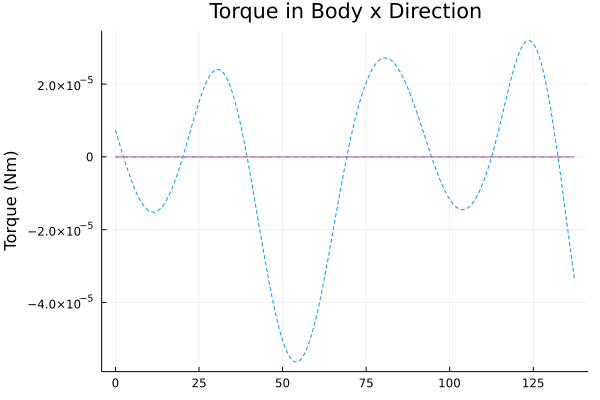

In [14]:
# x axis
px = plot(
    orbit_time./60, [Tm[i][1] for i in 1:length(Tm)], 
    label="Magnetic Torque",
#     xlabel="Time (min)",
    ylabel="Torque (Nm)",
    title="Torque in Body x Direction",
    legend=nothing,
    linestyle=:dash
)

plot!(orbit_time./60, [Tsp[i][1] for i in 1:length(Tsp)], label="Solar Pressure Torque", linestyle=:dot)
plot!(orbit_time./60, [Tg[i][1] for i in 1:length(Tg)], label="Gravity Gradient Torque", linestyle=:dashdot)
plot!(orbit_time./60, [Ta[i][1] for i in 1:length(Tg)], label="Aerodynamic Torque")

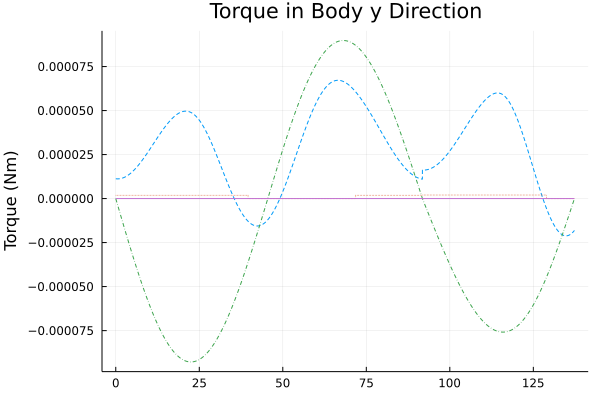

In [15]:
# y axis
py = plot(
    orbit_time./60, [Tm[i][2] for i in 1:length(Tm)], 
    label="Magnetic Torque",
#     xlabel="Time (min)",
    ylabel="Torque (Nm)",
    title="Torque in Body y Direction",
    legend=nothing,
    linestyle=:dash
)

plot!(orbit_time./60, [Tsp[i][2] for i in 1:length(Tsp)], label="Solar Pressure Torque", linestyle=:dot)
plot!(orbit_time./60, [Tg[i][2] for i in 1:length(Tg)], label="Gravity Gradient Torque", linestyle=:dashdot)
plot!(orbit_time./60, [Ta[i][2] for i in 1:length(Tg)], label="Aerodynamic Torque")

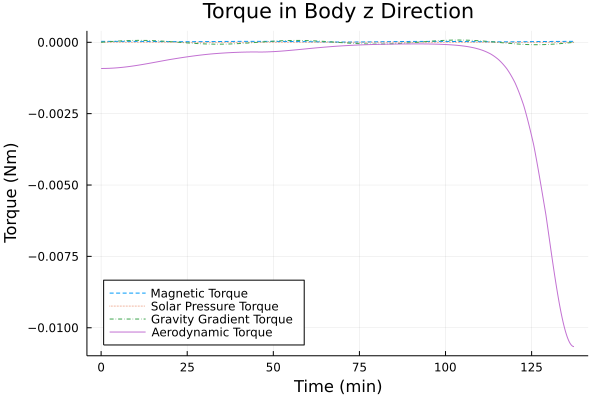

In [24]:
# x axis
pz = plot(
    orbit_time./60, [Tm[i][3] for i in 1:length(Tm)], 
    label="Magnetic Torque",
    xlabel="Time (min)",
    ylabel="Torque (Nm)",
    title="Torque in Body z Direction",
    linestyle=:dash,
    legend=:bottomleft
)

plot!(orbit_time./60, [Tsp[i][3] for i in 1:length(Tsp)], label="Solar Pressure Torque", linestyle=:dot)
plot!(orbit_time./60, [Tg[i][3] for i in 1:length(Tg)], label="Gravity Gradient Torque", linestyle=:dashdot)
plot!(orbit_time./60, [Ta[i][3] for i in 1:length(Tg)], label="Aerodynamic Torque")

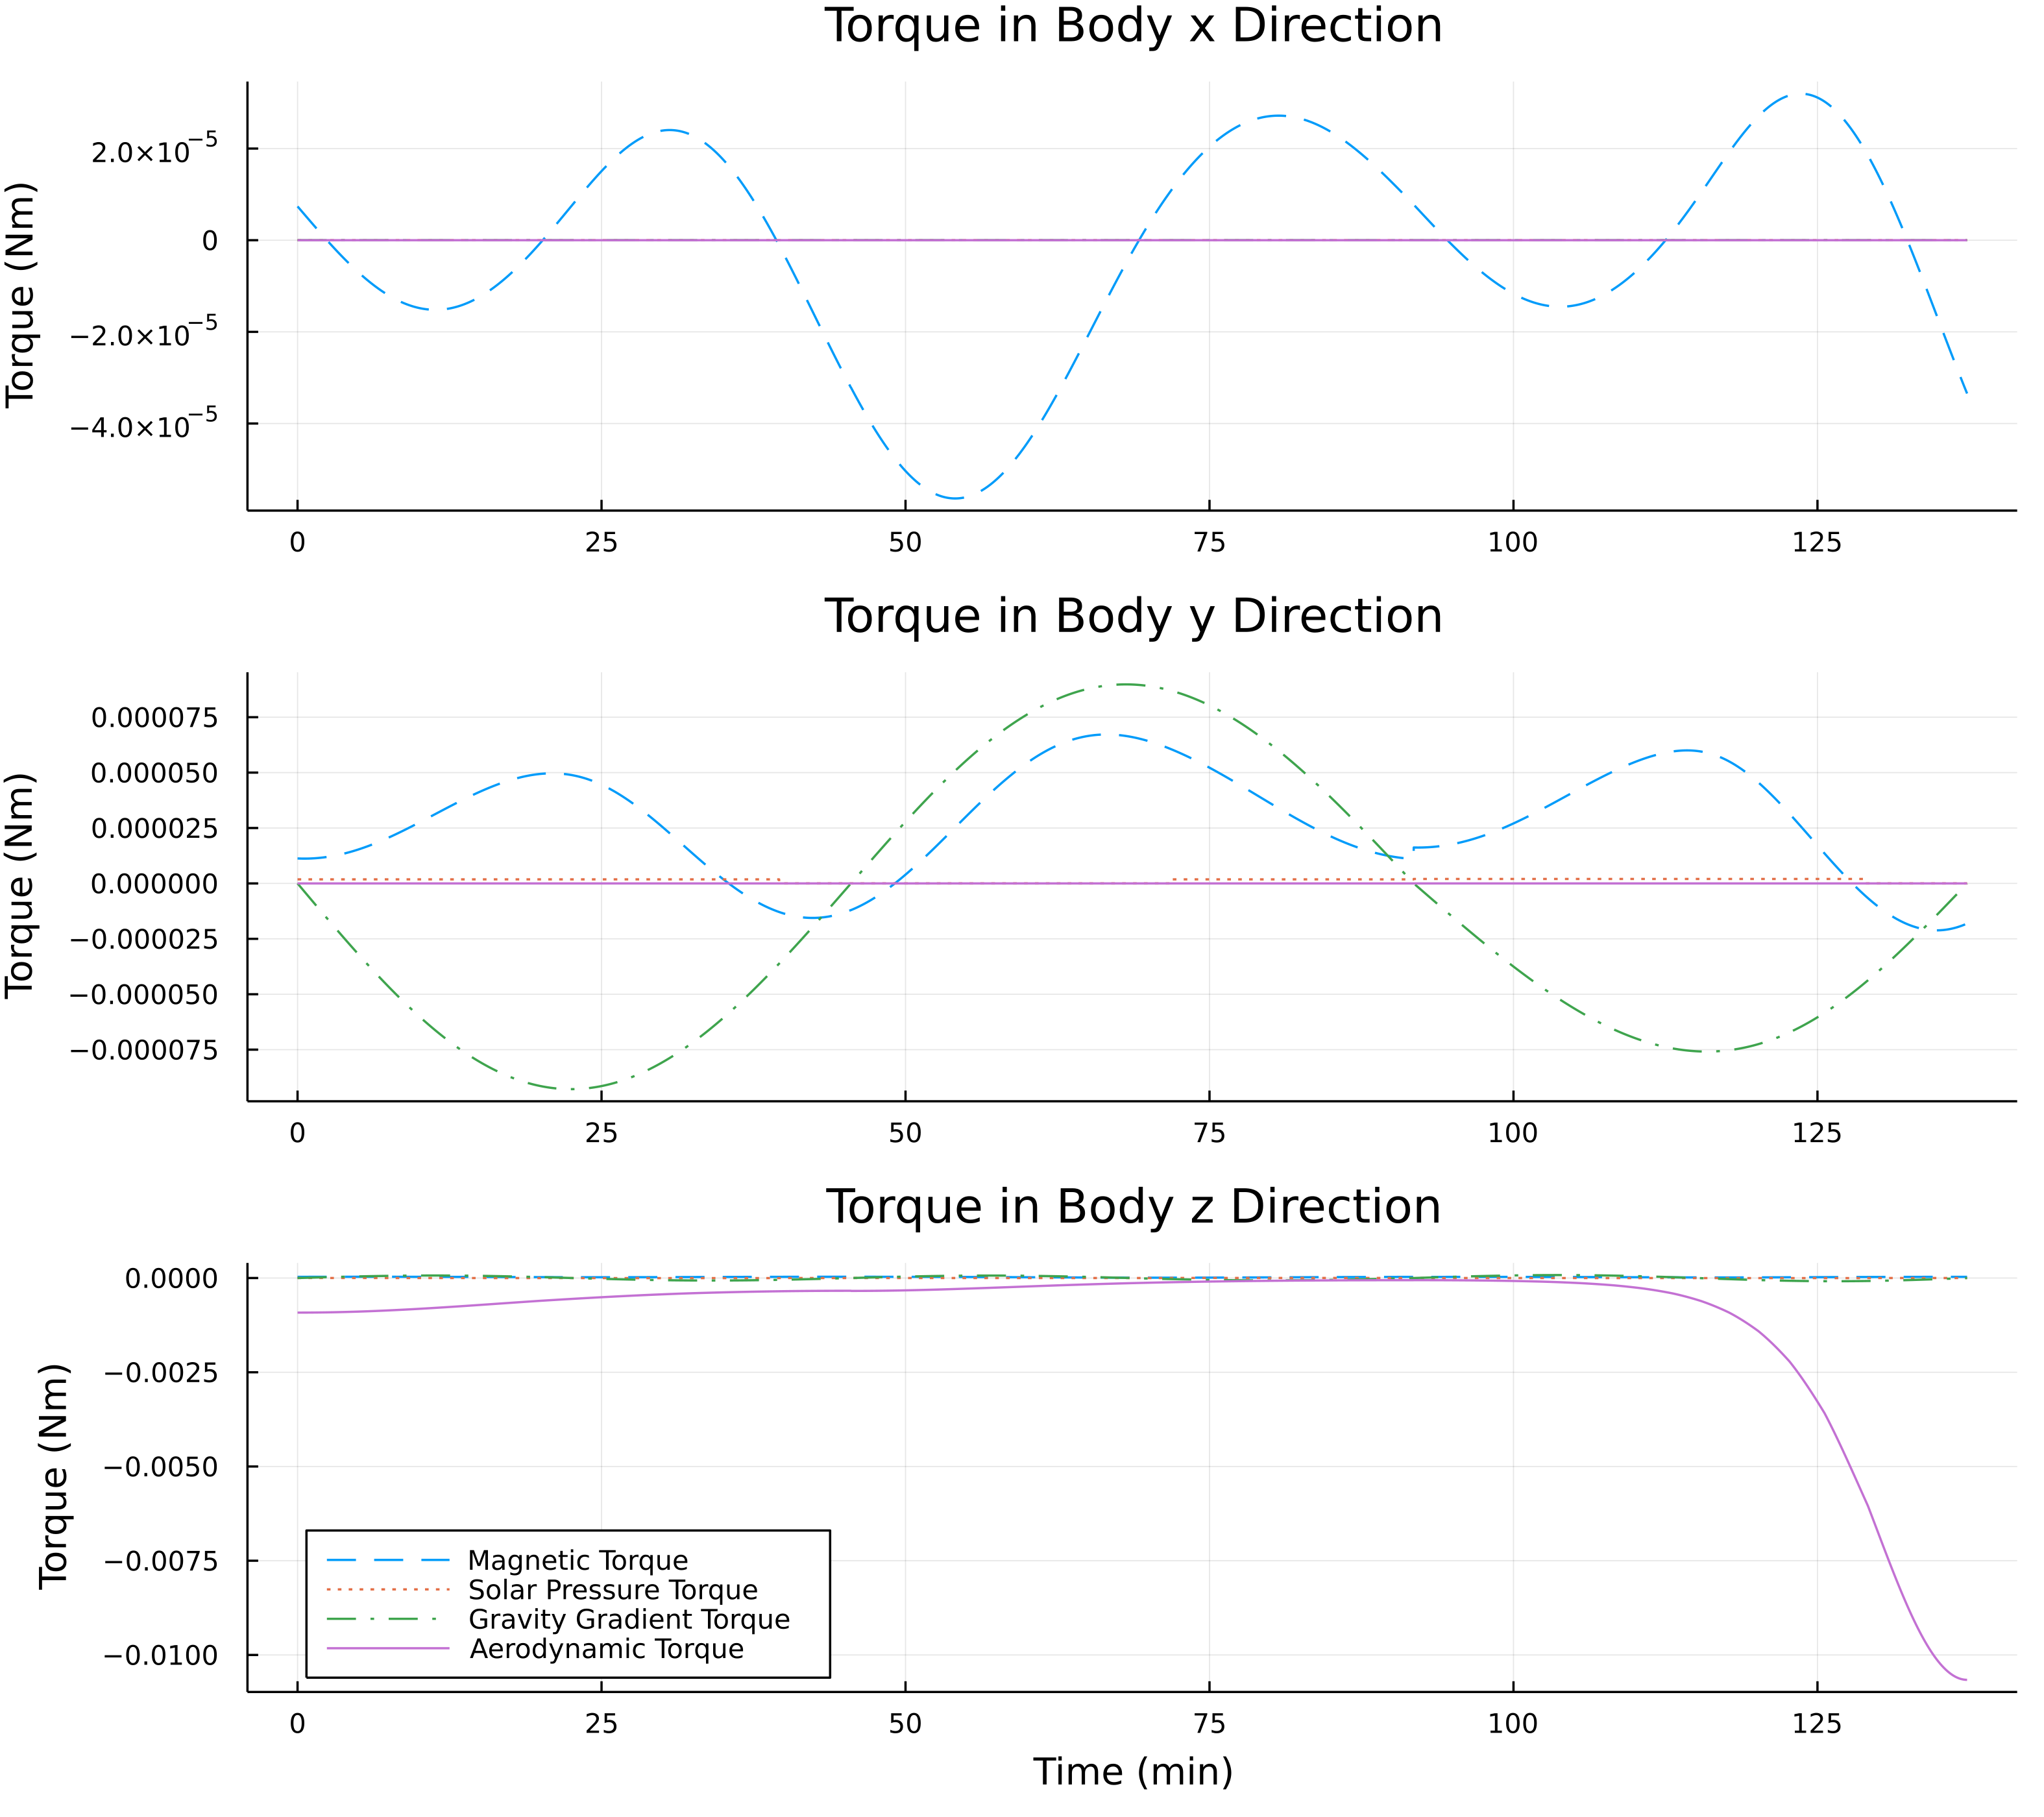

In [25]:
plot(px, py, pz, layout=(3, 1), size=(900,800), dpi=350, fmt=:png)

# Attitude Control

## Helper Functions

In [9]:
function inertial2LVLH(θ, i, Ω)
    R = [
        cos(θ)*cos(Ω)-sin(θ)*cos(i)*sin(Ω) -sin(θ)*cos(Ω)-cos(θ)*cos(i)*sin(Ω) sin(i)*sin(Ω)
        cos(θ)*sin(Ω)+sin(θ)*cos(i)*cos(Ω) -sin(θ)*sin(Ω)+cos(θ)*cos(i)*cos(Ω) -sin(i)*cos(Ω)
        sin(θ)*sin(i) cos(θ)*sin(i) cos(i)
    ]

    return R'
end

function get_angles_inertial2LVLH(C_LVLH_ECI)
    i = acos(C_LVLH_ECI[3,3])
    Ω = asin(C_LVLH_ECI[3,1] / sin(i))
    θ = asin(C_LVLH_ECI[1,3] / sin(i))
    
    return θ, i, Ω
end

# inertial2LVLH(0.0, deg2rad(55), deg2rad(-45))

get_angles_inertial2LVLH (generic function with 1 method)

In [10]:
function C_LVLH_B(θ1, θ2, θ3)
    return par_1(θ1) * par_2(θ2) * par_3(θ3)
end

function get_angles_body2LVLH(C_LVLH_B)
    theta2 = asin(-C_LVLH_B[1,3])
    theta1 = asin(C_LVLH_B[1,2] / cos(theta2))
    theta3 = asin(C_LVLH_B[2,3] / cos(theta2))
    
    return [theta1, theta2, theta3]
end

get_angles_body2LVLH (generic function with 1 method)

## Defining Attitude Dynamics

In [11]:
Jbi = [
    66.4151 0.0 0.0
    0.0 66.4151 0.0
    0.0 0.0 116.163
]

# C_LVLH_B
function Body2LVLH(θ1, θ2, θ3)
    return par_1(θ1) * par_2(θ2) * par_3(θ3)
end

# θ, ω values wrt. LVLH reference frame

function diffeq_euler(initial_conditions, time_span, params; solver_args...)
    function _differential_system!(u, p, t)
        θ1, θ2, θ3, ω1, ω2, ω3 = u        
        J1, J2, J3, M1_func, M2_func, M3_func, C_NL_init = p

        SA[
            ω1,
            ω2,
            ω3,
            (M1_func(u, p, t) + (J2 - J3) * ω2 * ω3) / J1,
            (M2_func(u, p, t) + (J3 - J1) * ω1 * ω3) / J2,
            (M3_func(u, p, t) + (J1 - J2) * ω1 * ω2) / J3
        ]
    end
    
    problem = ODEProblem(_differential_system!, initial_conditions, time_span, params)
    solution = solve(problem; solver_args...)

    return solution
end

omega_n = 0.25
zeta = 0.8

Js = [Jbi[1,1], Jbi[2,2], Jbi[3,3]]
Kp = Js .* omega_n^2
Kd = 2 .* Js .* omega_n .* zeta

orbit_x_interp = QuadraticInterpolation(orbit_x, orbit_time)
orbit_y_interp = QuadraticInterpolation(orbit_y, orbit_time)
orbit_z_interp = QuadraticInterpolation(orbit_z, orbit_time)

orbit_vx_interp = QuadraticInterpolation(orbit_vx, orbit_time)
orbit_vy_interp = QuadraticInterpolation(orbit_vy, orbit_time)
orbit_vz_interp = QuadraticInterpolation(orbit_vz, orbit_time)

θref = [0, 0, 0]
ωref = [0, 0, 0]

function orbit_interp(t)
    return orbit_x_interp(t), orbit_y_interp(t), orbit_z_interp(t), orbit_vx_interp(t), orbit_vy_interp(t), orbit_vz_interp(t)
end

function ω_orbit(x, y, z, vx, vy, vz)
    return norm(cross([x, y, z], [vx, vy, vz])) / norm([x, y, z])^2
end

function body_disturbance_torque(dir_index, orbit_params, C_LVLH_N, C_B_LVLH)
    x, y, z, vx, vy, vz = orbit_params
    
    Tm = (C_B_LVLH * magnetic_torque([1,1,1], [x, y, z], C_LVLH_N))
    Tsp = (C_B_LVLH * solarpressure_torque(in_sun_func([x, y, z], r_unit_sun), r_unit_sun, 2.287, [-0.2595, 0.0, 0.0], C_LVLH_N))
    Tg = (C_B_LVLH * gravitygradient_torque([x,y,z], Jbi, C_LVLH_N))
    Ta = (C_B_LVLH * aerodynamic_torque([x,y,z], [vx,vy,vz], 2.287, [-0.2595, 0.0, 0.0], C_LVLH_N))
    
    return Tm[dir_index] + Tsp[dir_index] + Tg[dir_index] + Ta[dir_index]
end

function Mx_PD(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3  = u        
    J1, J2, J3, C_NL_init = p[1], p[2], p[3], p[7]
    
    x, y, z, vx, vy, vz = orbit_interp(t)
    
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(θ1, θ2, θ3)
    
    Td = body_disturbance_torque(1, [x, y, z, vx, vy, vz], C_LVLH_N, C_B_LVLH)
    
    Δθ1 = get_angles_body2LVLH(C_LVLH_N * C_NL_init)[1]
    
    return Td + Kp[1]*((Δθ1 + θref[1]) - θ1) + Kd[1]*((ω_orbit(x, y, z, vx, vy, vz) + ωref[1]) - ω1)
end

function My_PD(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3  = u        
    J1, J2, J3, C_NL_init = p[1], p[2], p[3], p[7]
    
    x, y, z, vx, vy, vz = orbit_interp(t)
    
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(θ1, θ2, θ3)
    
    Td = body_disturbance_torque(2, [x, y, z, vx, vy, vz], C_LVLH_N, C_B_LVLH)
    
    Δθ2 = get_angles_body2LVLH(C_LVLH_N * C_NL_init)[2]
    
    return Td + Kp[2]*((Δθ2 + θref[2]) - θ2) + Kd[2]*(ωref[2] - ω2)
end

function Mz_PD(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3  = u        
    J1, J2, J3, C_NL_init = p[1], p[2], p[3], p[7]
    
    x, y, z, vx, vy, vz = orbit_interp(t)
    
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(θ1, θ2, θ3)
    
    Td = body_disturbance_torque(3, [x, y, z, vx, vy, vz], C_LVLH_N, C_B_LVLH)
    
    Δθ3 = get_angles_body2LVLH(C_LVLH_N * C_NL_init)[3]
    
    return Td + Kp[3]*((Δθ3 + θref[3]) - θ3) + Kd[3]*(ωref[3] - ω3)
end

function Mx_D(u, p, t)
    x, y, z, vx, vy, vz = orbit_interp(t)
    
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(u[1], u[2], u[3])
    
    Td = body_disturbance_torque(1, [x, y, z, vx, vy, vz], C_LVLH_N, C_B_LVLH)
    
    return Td
end

function My_D(u, p, t)
    x, y, z, vx, vy, vz = orbit_interp(t)
    
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(u[1], u[2], u[3])
    
    Td = body_disturbance_torque(2, [x, y, z, vx, vy, vz], C_LVLH_N, C_B_LVLH)
    
    return Td
end

function Mz_D(u, p, t)    
    x, y, z, vx, vy, vz = orbit_interp(t)
    
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(u[1], u[2], u[3])
    
    Td = body_disturbance_torque(3, [x, y, z, vx, vy, vz], C_LVLH_N, C_B_LVLH)
    
    return Td
end

Mx_N(u, p, t) = 0
My_N(u, p, t) = 0
Mz_N(u, p, t) = 0

Mz_N (generic function with 1 method)

In [12]:
M1_func(u, p, t) = Kp[1]*(θ_ref[1] - u[1]) + Kd[1]*(ω_ref[1] - u[4])
M2_func(u, p, t) = Kp[2]*(θ_ref[2] - u[2]) + Kd[2]*(ω_ref[2] - u[5])
M3_func(u, p, t) = Kp[3]*(θ_ref[3] - u[3]) + Kd[3]*(ω_ref[3] - u[6])

M3_func (generic function with 1 method)

In [48]:
function u_RCS(θ, ω, θdb, ωdb, J, T; τ=1)
    abs(θ) <= θdb && abs(ω) <= ωdb ? u = 0 : u = -T * sign(θ + τ*ω)
    
    return u
end

θ_deadband = [0.01, 0.01, 0.01]
ω_deadband = [0.01, 0.01, 0.01]

Mx = 0.5
My = 0.5
Mz = 0.5

function Mx_RCS(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]
    
    Td_x = Mx_D(u, p, t)
    
    x, y, z, vx, vy, vz = orbit_interp(t)
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(θ1, θ2, θ3)
    Δθ1 = get_angles_body2LVLH(C_LVLH_N * C_NL_init)[1]
    
    if t >= 17.56306*60.0
        return Td_x + u_RCS(Δθ1 + θ1, ω1, θ_deadband[1], ω_deadband[1], J1, Mx)
    else
        return Td_x
    end
#     return Td_x + u_RCS(Δθ1 + θ1, ω1, θ_deadband[1], ω_deadband[1], J1, Mx)
end

function My_RCS(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]
    
    Td_y = My_D(u, p, t)
    
    x, y, z, vx, vy, vz = orbit_interp(t)
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(θ1, θ2, θ3)
    Δθ2 = get_angles_body2LVLH(C_LVLH_N * C_NL_init)[2]
    
    if t >= 17.56306*60.0
        return Td_y + u_RCS(Δθ2 + θ2, ω2, θ_deadband[2], ω_deadband[2], J2, My)
    else
        return Td_y
    end
#     return Td_y + u_RCS(Δθ2 + θ2, ω2, θ_deadband[2], ω_deadband[2], J2, My)
end

function Mz_RCS(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]
    
    Td_z = Mz_D(u, p, t)
    
    x, y, z, vx, vy, vz = orbit_interp(t)
    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
    C_B_LVLH = Body2LVLH(θ1, θ2, θ3)
    Δθ3 = get_angles_body2LVLH(C_LVLH_N * C_NL_init)[3]
    
    if t >= 12.56306*60.0
        return Td_z + u_RCS(Δθ3 + θ3, ω3, θ_deadband[3], ω_deadband[3], J3, Mz)
    else
        return Td_z
    end
#     return Td_z + u_RCS(Δθ3 + θ3, ω3, θ_deadband[3], ω_deadband[3], J3, Mz)
end

Mz_RCS (generic function with 1 method)

In [40]:
# # update relative angles on inclination change
# function condition1(u, t, integrator)
#     x, y, z, vx, vy, vz = orbit_interp(t)
#     C_L_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
#     ifloat = rad2deg(get_angles_inertial2LVLH(C_L_N)[2])
    
#     i = convert(Int64, round(ifloat))
    
#     return integrator.p[7] != i
# end

# function affect1!(integrator)
#     x, y, z, vx, vy, vz = orbit_interp(integrator.t)
#     C_LN_new = C_LVLH_ECEF2(x, y, z, vx, vy, vz)
#     θ, i, Ω = get_angles_inertial2LVLH(C_LN_new)
    
#     C_LN_old = inertial2LVLH(θ, integrator.p[7], 0)
    
#     θx_new, θy_new, θz_new = get_angles_body2LVLH(C_LN_old * C_LN_new')
    
#     integrator.p[7] = convert(Int64, round(rad2deg(i)))
    
#     integrator.u[1] += θx_new
#     integrator.u[2] += θy_new
#     integrator.u[3] += θz_new
# end

# reset z axis angle to zero
condition1(u, t, integrator) = u[3] <= -2*π

function affect1!(integrator)
    integrator.u[3] = 0
    
    nothing
end

cb1 = DiscreteCallback(condition1, affect1!)

# stop active control during deorbit trajectory
condition2(u, t, integrator) = t >= 5507.833359886708

function affect2!(integrator)
    integrator.p[4] = Mx_D
    integrator.p[5] = My_D
    integrator.p[6] = Mz_D
    
    nothing
end

cb2 = DiscreteCallback(condition2, affect2!)

cb_set = CallbackSet(cb1, cb2);

## Simulation and Results

In [49]:
# time_end = 60.0
# time_end = orbit_time[end]

θ_rand = 0.25
ω_rand = 0.1

# random initial angles and angular velocities
# simulating deployment from ground launcher
# θ_deployment = rand(Uniform(-θ_rand, θ_rand), 3)
# ω_deployment = rand(Uniform(-ω_rand, ω_rand), 3)

# attitude_init = [
#     θ_deployment
#     ω_deployment
# ]

attitude_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# attitude_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

C_NL_init = C_LVLH_ECEF2(orbit_x[1], orbit_y[1], orbit_z[1], orbit_vx[1], orbit_vy[1], orbit_vz[1])'

# attitude_tspan = (0.0, time_end)

# start to first burn
attitude_tspan = (0.0, 22.56306*60)
# attitude_tspan = (0.0, 30.0*60.0)

# attitude_params = [Js[1], Js[2], Js[3], Mx_PD, My_PD, Mz_PD, C_NL_init]

attitude_params = [Js[1], Js[2], Js[3], Mx_RCS, My_RCS, Mz_RCS, C_NL_init]

# attitude_params = [Js[1], Js[2], Js[3], Mx_D, My_D, Mz_D, C_NL_init]

attitude_sol = diffeq_euler(
    attitude_init, attitude_tspan, attitude_params, 
    reltol=5e-6, abstol=5e-6
);

In [50]:
times = LinRange(0.0, attitude_tspan[2], 5000)
sol_interp = attitude_sol(times)

theta_1 = sol_interp[1, 1:end]
theta_2 = sol_interp[2, 1:end]
theta_3 = sol_interp[3, 1:end]

omega_1 = sol_interp[4, 1:end]
omega_2 = sol_interp[5, 1:end]
omega_3 = sol_interp[6, 1:end]

#    C_LVLH_N = C_LVLH_ECEF2(x, y, z, vx, vy, vz)

# anomaly, inclination, raan = get_angles_inertial2LVLH.()
C_LVLH_N = C_LVLH_ECEF2.(
    orbit_x_interp.(times),
    orbit_y_interp.(times), 
    orbit_z_interp.(times),
    orbit_vx_interp.(times),
    orbit_vy_interp.(times), 
    orbit_vz_interp.(times)
)

C_LB = [C_LN * C_LVLH_N[1]' for C_LN in C_LVLH_N]

Δθ1 = [res[1] for res in get_angles_body2LVLH.(C_LB)]
Δθ2 = [res[2] for res in get_angles_body2LVLH.(C_LB)]
Δθ3 = [res[3] for res in get_angles_body2LVLH.(C_LB)];

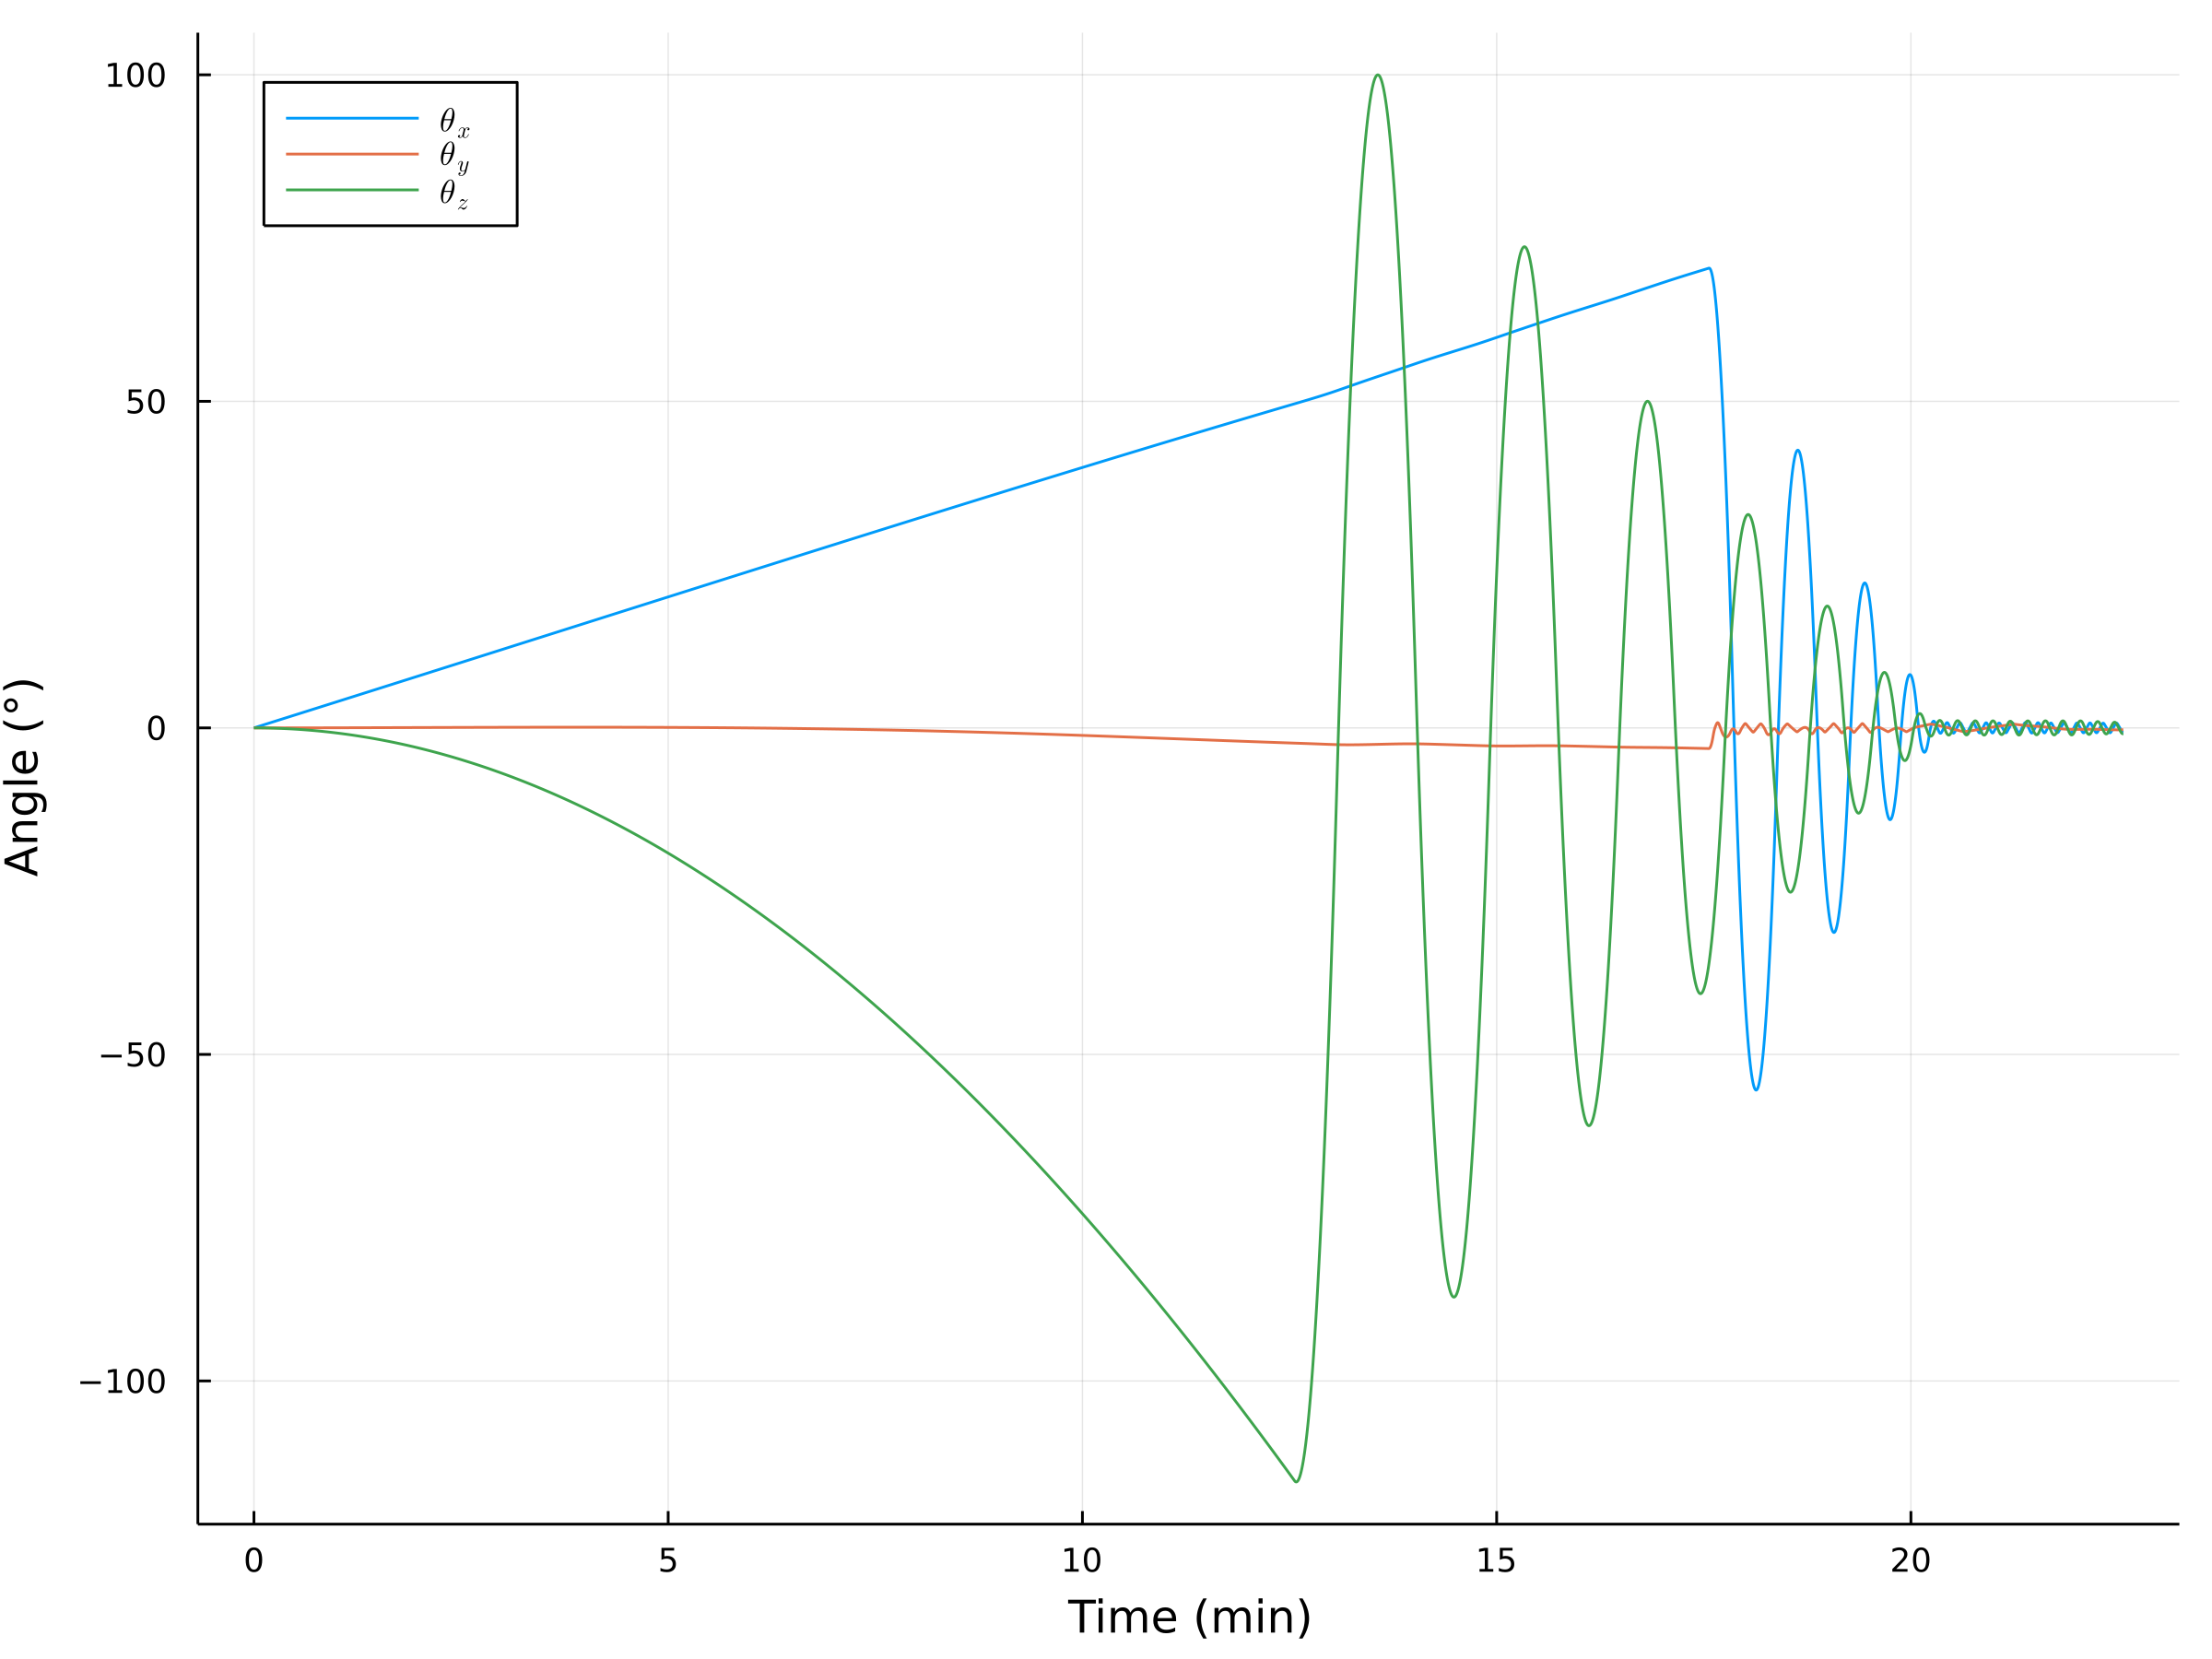

In [51]:
fig1 = plot(
    times ./ 60, rad2deg.(theta_1 .+ Δθ1), 
    label=L"\theta_x", 
    ylabel="Angle (°)", 
    xlabel="Time (min)",
    legend=:topleft,
    size=(800,600),
    dpi=300,
    fmt=:png,
#     ylim=(-30,30)
)
plot!(times ./ 60,  rad2deg.(theta_2 .- Δθ2), label=L"\theta_y")
plot!(times ./ 60,  rad2deg.(theta_3 .- Δθ3), label=L"\theta_z")

In [113]:
# # # exporting results
# matwrite("baseline_RCS_test.mat", Dict(
#     "time" => collect(times),
#     "theta_1_out" => theta_1.+ Δθ1,
#     "theta_2_out" => theta_2.- Δθ2,
#     "theta_3_out" => theta_3.- Δθ3,
#     "omega_1_out" => omega_1,
#     "omega_2_out" => omega_2,
#     "omega_3_out" => omega_3
# ));

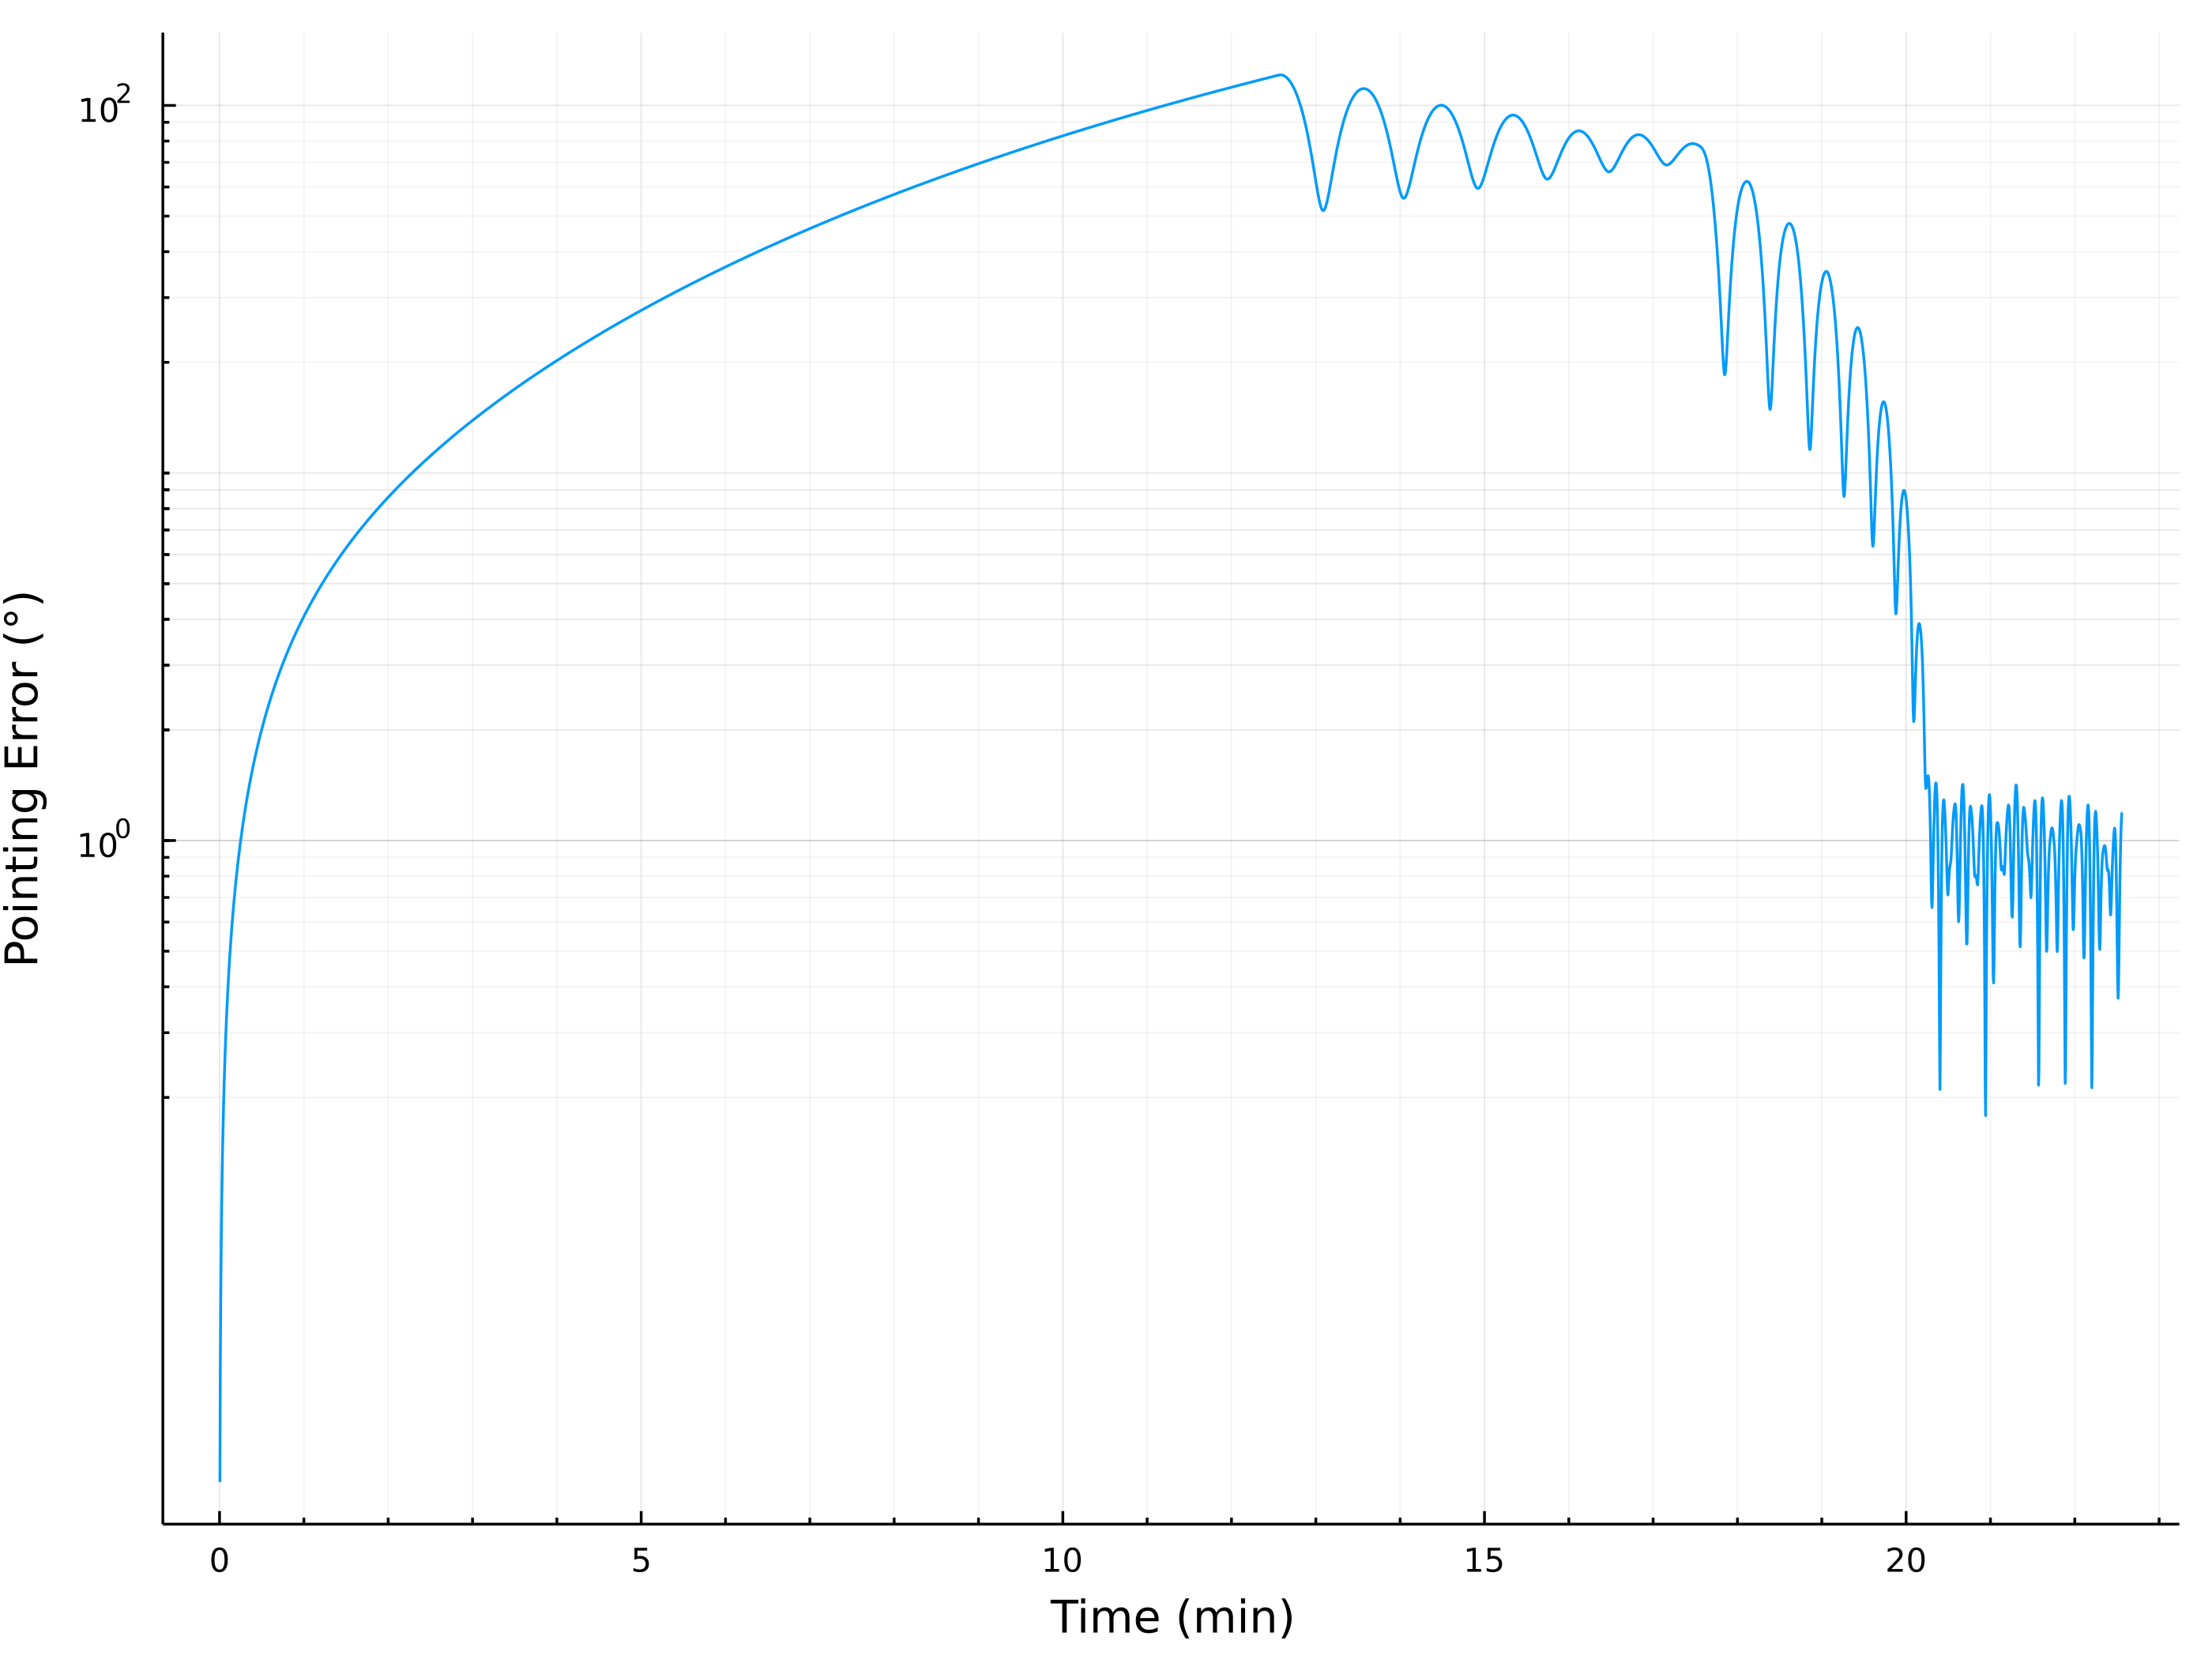

In [53]:
# testing pointing accuracy
function dcm_deviation(C, C_true)
    CN = C * C_true'
    return acos(0.5 * (trace(CN) - 1))
end

function C_LVLH_B(θ1, θ2, θ3)
    return par_1(θ1) * par_2(θ2) * par_3(θ3)
end

C_LB = C_LVLH_B.(theta_1 .+ Δθ1, theta_2 .- Δθ2, theta_3 .- Δθ3)

pointing_error = [dcm_deviation(C, I(3)) for C in C_LB]

plot(
    times[2:end] ./ 60, rad2deg.(pointing_error[2:end]), 
    label="", 
    xlabel="Time (min)",
    ylabel="Pointing Error (°)",
    size=(800,600),
    dpi=350,
    fmt=:png,
    yaxis=:log,
    minorgrid=true
)

In [128]:
# plot(
#     times[900:end] ./ 60, rad2deg.(pointing_error[900:end]), 
#     label="", 
#     xlabel="Time (min)",
#     ylabel="Pointing Error (°)",
#     size=(600,400),
#     dpi=350,
#     fmt=:png,
#     yaxis=:log,
#     minorgrid=true
# )

rad2deg(mean(pointing_error[4500:end]))

0.9139712721005218

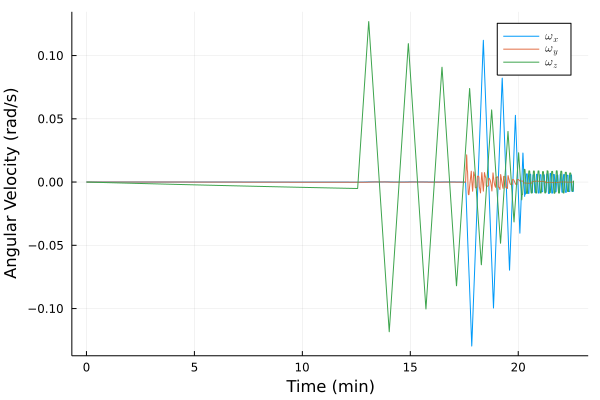

In [18]:
fig2 = plot(
    times ./ 60, omega_1, 
    label=L"\omega_x", 
    xlabel="Time (min)", 
    ylabel="Angular Velocity (rad/s)", 
    legend=:topright
)

plot!(times ./ 60, omega_2, label=L"\omega_y")
plot!(times ./ 60, omega_3, label=L"\omega_z")

# plot(fig1, fig2, layout=(2,1), size=(800, 600), dpi=300)

# burn: 22.56306
# start: 17.56306

## Exporting Results

In [21]:
# sol_interp_out = attitude_sol(orbit_time)

# theta_1_out = sol_interp_out[1, 1:end]
# theta_2_out = sol_interp_out[2, 1:end]
# theta_3_out = sol_interp_out[3, 1:end]

# omega_1_out = sol_interp_out[4, 1:end]
# omega_2_out = sol_interp_out[5, 1:end]
# omega_3_out = sol_interp_out[6, 1:end]

# matwrite("baseline_mission_attitude.mat", Dict(
#     "time" => orbit_time,
#     "theta_1_out" => theta_1_out,
#     "theta_2_out" => theta_2_out,
#     "theta_3_out" => theta_3_out,
#     "omega_1_out" => omega_1_out,
#     "omega_2_out" => omega_2_out,
#     "omega_3_out" => omega_3_out
# ));

# Visualizations

In [51]:
plot(orbit_x, orbit_y, orbit_z, size=(900,900), label="")

X(r,theta,phi) = r * sin(theta) * sin(phi)
Y(r,theta,phi) = r * sin(theta) * cos(phi)
Z(r,theta,phi) = r * cos(theta)

thetas = range(0, stop=2*π, length=50)
phis   = range(0, stop=2*π, length=50)

xs = [X(re, theta, phi) for theta in thetas, phi in phis] 
ys = [Y(re, theta, phi) for theta in thetas, phi in phis]
zs = [Z(re, theta, phi) for theta in thetas, phi in phis]

surface!(xs, ys, zs, colorbar=nothing, color=:lightblue)